## Project: Stock Prediction
### Make an app which applies Machine Learning to predict the price increase or decrease in the next day.

### 1) Who will be benefited from this program?
      -- People who wants a small investment in the stock. 
      -- People who has a few knowledge of the stock.
      -- People who don't want to spend too much time in studying the stock.

### 2) What is difference from this program to the others?
      -- Applying Machine Learning methods (LSTM, NN, etc) to study each stock.
      -- Giving statistic but "friendly" results.

## Data

yfinance is a popular open source library developed by Ran Aroussi as a means to access the financial data available on Yahoo Finance.

    -- Free
    -- Quick and easy to set up
    -- Simple
    -- High granularity of data (1min/2min/5min)

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt

tickerSymbol = 'GOOG'

#get data
tickerData = yf.Ticker(tickerSymbol)

#get data in the time 
ticker_df = tickerData.history(period='1d', start='2010-1-1', end='2020-1-1')

In [54]:
# data structure
ticker_df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04,312.304413,313.579620,310.954468,312.204773,3927000,0,0.0
2010-01-05,312.418976,312.747742,309.609497,310.829926,6031900,0,0.0
2010-01-06,311.761444,311.761444,302.047852,302.994293,7987100,0,0.0
2010-01-07,303.562164,303.861053,295.218445,295.940735,12876600,0,0.0
2010-01-08,294.894653,300.498657,293.455048,299.885956,9483900,0,0.0


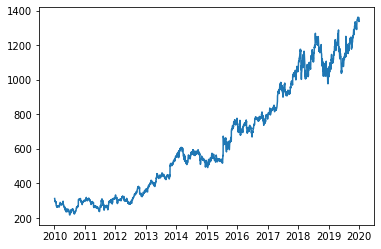

In [55]:
#close price 
plt.plot(ticker_df['Close'])

### Idea
    The close price will go up or down in the next day?

### Simpliest NN Model
    -- Input: stock price in the last 50 days. 
    -- Output: stock price will go up or down.

In [11]:
#collect data
import pandas as pd
import numpy as np
train=[]
for i in range(1000):
    tmp = ticker_df['Close'][i+51]-ticker_df['Close'][i+50]
    if tmp >= 0:
        train.append([np.array(ticker_df['Close'][i:i+50]),[1,0]])
    else:
        train.append([np.array(ticker_df['Close'][i:i+50]),[0,1]])
np.random.shuffle(train)
VLC_PCT=0.1
val_size=int(len(train)*VLC_PCT)

train_df=train[:-val_size]
test_df=train[-val_size:]

In [58]:
## NN Model
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
       
        self.fc1 = nn.Linear(50, 50)  
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=0)

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


In [62]:
#train the model
import torch.optim as optim
from tqdm import tqdm
optimizer = optim.Adam(net.parameters(),lr=1e-3)
loss_function=nn.MSELoss()

x=torch.Tensor([i[0] for i in train_df]).view(-1,50)
y=torch.Tensor([i[1] for i in train_df])

batch_size=20
epochs = 3
for epoch in range(epochs):
    for i in tqdm(range(0,len(x),batch_size)):
        batch_x = x[i:i+batch_size].view(-1,1,50)
        batch_y = y[i:i+batch_size]
        
        net.zero_grad()
        outputs = net(batch_x)
        loss=loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()        



100%|██████████| 45/45 [00:00<00:00, 1005.92it/s]


In [65]:
x=torch.Tensor([i[0] for i in test_df]).view(-1,50)
y=torch.Tensor([i[1] for i in test_df])

correct=0
total=0
with torch.no_grad():
    for i in range(len(x)):
        real_class=torch.argmax(y[i])
        net_out=net(x[i].view(-1,1,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class==real_class:
            correct +=1
        total+=1
print ("Accuracy:",correct/total)

Accuracy: 0.52


In [29]:
scaler_data

array([[0., 0., 0., ..., 0., 0., 0.]])

In [32]:
#LSTM Data
import numpy as np
from sklearn.preprocessing import MinMaxScaler

lstm_data = ticker_df.filter(['Close'])
lstm_data = lstm_data.values

scaler=MinMaxScaler(feature_range=(0,1))
scaler_data = scaler.fit_transform(lstm_data)

train_data = scaler_data[0:int(len(lstm_data)*0.9),:]

train_x = []
train_y = []
for i in range(80,len(train_data)):
    train_x.append(train_data[i-80:i])
    train_y.append(train_data[i])
    
train_x = np.reshape(train_x,(len(train_x),80,1))
train_x = np.array(train_x)
train_y = np.array(train_y)

In [34]:
#LSTM Model
#by randerson112358's blog
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model=Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(train_x.shape[1],1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(train_x,train_y,batch_size=1,epochs=1)


2184/2184 [==============================] - 88s 40ms/step - loss: 0.0011


In [35]:
test_data = scaler_data[int(len(lstm_data)*0.9):]

test_x=[]
test_y=[]

for i in range(80,len(test_data)):
    test_x.append(test_data[i-80:i])
    test_y.append(test_data[i])
    
test_x=np.array(test_x)
test_x=np.reshape(test_x,(test_x.shape[0],test_x.shape[1],1))

predictions=model.predict(test_x)
predictions = scaler.inverse_transform(predictions)
test_y =scaler.inverse_transform(test_y)

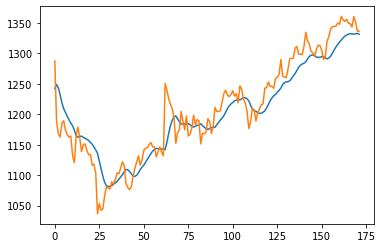

In [40]:
plt.plot(predictions)
plt.plot(test_y)

In [42]:
correct=0
total=0

for i in range(1,len(test_y)):
    if test_y[i]-test_y[i-1] >=0:
        if predictions[i]-test_y[i-1] >=0:
            correct+=1
    else:
        if predictions[i]-test_y[i-1] < 0:
            correct+=1
    total+=1

print ("Accuracy:",correct/total)
    

Accuracy: 0.5497076023391813


### Results to show
    -- Prediction: up or down.
    -- Prediction in the last 20 days.
    -- Prediction from different models.

### Future work
    -- Tuning hyperparameters
    -- Add more features: open, high, low, volumne, stock index,etc.
    -- Add more models
    